## 「単語のベクトル表現」の必要性

+ 画像や音声：
    + リッチで高次元な（密な）ベクトルデータ
        + 画像：個々のピクセル強度のベクトル
        + 音声：パワースペクトル密度係数のベクトル
    + 必要なすべての情報がデータに符号化されている（と見做せる）
+ 自然言語：
    + （伝統的に）「単語」を個別の「元素記号」として扱う
    + それぞれの「記号」間に存在する（かもしれない）有益な情報は提供されない
    + ⇒ データは「疎」になる
        + ↑うまく訓練（学習）するには大量のデータが必要になる…。

そこで → 単語（記号）の「ベクトル表現」

+ （単語の）「ベクトル空間モデル」：
    + 連続したベクトル空間
    + その座標（点）に「単語」を埋め込む
        + 意味論的に類似する単語は互いに近い位置に埋め込まれる
    + 埋め込む方法：分布仮説に依存
        + 分布仮説：「同じ**コンテキスト**（文脈）において出現する単語は意味論的な意味を共有する」という主張
        + カウントベースメソッド：隣接事共起する頻度の統計を取ってマップする方法
        + 予測的メソッド：小さく密なベクトル（＝モデルのパラメータ）を学習（⇒**予測モデル**）

### Word2Vec

+ 生のテキストから単語の埋め込みを学習するための、計算効率の高い予測モデル
+ さらに2種類：
    + 連続単語集合モデル（CBOW）：
        + コンテキスト（例：『猫が座る』）からターゲット単語（例：『マット』）を予測
        + （コンテキスト全体を一つの観測値として扱うことにより）多くの分布情報を平滑化するという効果
        + （多くの場合）より小さなデータセットで有用
    + **Skip-Gram モデル**：
        + ターゲット単語から元のコンテキストを予測（CBOWの逆）
        + 各コンテキスト・ターゲット単語のペアを新たな観測値として扱う
        + より大きなデータセットの場合に有用

## Noise-Contrastive 訓練

+ CBOW や skip-gram モデルで利用される訓練（学習）法
+ ターゲット単語と、それ以外の（任意のk個の）ノイズ単語との2値分類（ロジスティック回帰）を利用
    + ↑完全な確率モデルではない
    + でも極限的に softmax に漸近
    + ⇒ 十分実用的で、計算効率高い！


## Skip-Gram モデル

例：以下のデータセットを利用：
> the quick brown fox jumped over the lazy dog

+ 「コンテキスト」を「ターゲット単語の左右N個ずつの単語群の窓」と定義
    + N：窓サイズ
    + 例：窓サイズ N=1 とすると：  
      ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...
+ Skip-Gram は「ターゲット単語からコンテキストを予測」  
  →入力と出力のペアは以下のような感じ：  
  (quick, the), (quick, brown), (brown, quick), (brown, fox), ...

## グラフの構築

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf


In [2]:
# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

In [3]:
filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data


In [5]:
words = read_data(filename)
print('Data size', len(words))

Data size 17005207


In [6]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary


In [7]:
data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5241, 3082, 12, 6, 195, 2, 3135, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [8]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels


In [9]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
            '->', labels[i, 0], reverse_dictionary[labels[i, 0]])


3082 originated -> 12 as
3082 originated -> 5241 anarchism
12 as -> 3082 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of


In [10]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.


In [11]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
                tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
                tf.truncated_normal([vocabulary_size, embedding_size],
                                                        stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, embed, train_labels,
                                         num_sampled, vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
            normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
            valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.initialize_all_variables()


In [12]:
# Step 5: Begin training.
num_steps = 100001

In [13]:
with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
                batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  293.645874023
Nearest to had: append, revolutionaries, joaquim, gg, collaborators, animators, preaching, tz,
Nearest to between: commercialize, chlorine, meritocratic, luoyang, ghetto, asu, hanging, mak,
Nearest to one: freya, benny, franchise, boyz, speght, piaget, finds, punctured,
Nearest to use: maligned, attraction, liu, beaten, zech, shaking, sinai, apprehended,
Nearest to state: fulfillment, shield, provincias, fairy, scarecrow, brythonic, deflect, discoveries,
Nearest to over: finale, due, van, meltzer, specs, revulsion, tedious, dialect,
Nearest to if: skimmed, hotline, gentile, helpful, celibacy, shops, longing, subgenus,
Nearest to all: lenient, repudiate, napalm, buckets, fantastic, mashal, assists, mountain,
Nearest to by: aleuts, flavours, patton, sicily, strung, gloria, hijra, remote,
Nearest to first: botany, mahler, disgraceful, winter, landis, personification, pstn, meiji,
Nearest to would: haworth, contesting, palladium, kierkeg

In [14]:
# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    # plt.savefig(filename)
    plt.show()


In [19]:
%matplotlib inline

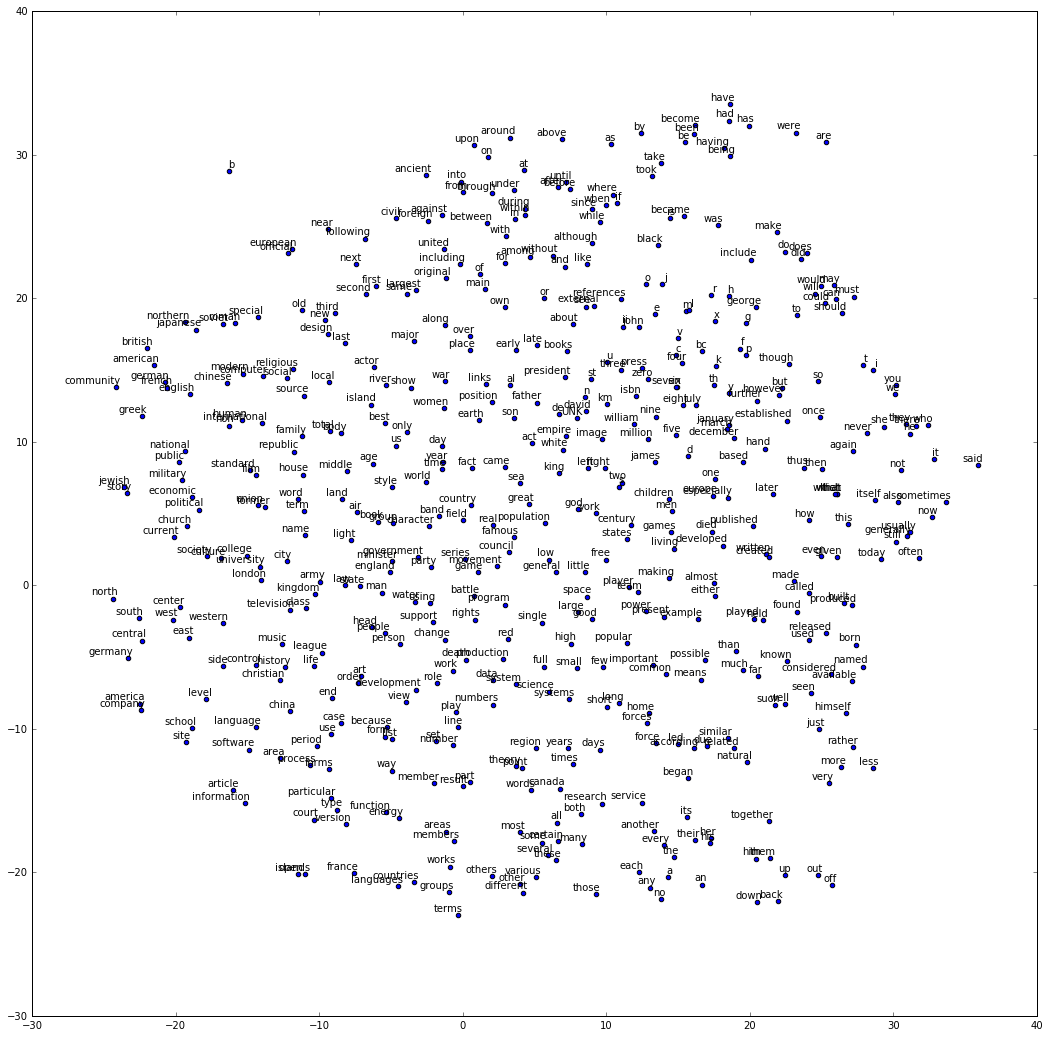

In [20]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")


## 参考

+ [Vector Representations of Words](https://www.tensorflow.org/tutorials/word2vec/index.html)（TensorFlow 公式チュートリアル）
    + [参考日本語訳その1](http://qiita.com/KojiOhki/items/b0bf5f48ecdf513a7f5b)
    + [参考日本語訳その2](http://tensorflow.classcat.com/2016/03/12/tensorflow-cc-word2vec/)